#### Imports and Read Data

In [2]:
from itertools import chain, combinations
from time import perf_counter
import pathlib
from volume_feature import add_powerset_created, add_powerset_open
import pandas as pd

from utils import get_connection, get_311_data, powerset, make_rounded_time_column


In [14]:
# df = load_saved_data()
root_dir = pathlib.Path("../data")
dir_2018 = root_dir/"311/2018"
try:
    df = pd.read_parquet(dir_2018/"unprocessed")
    if len(df) == 0:
        raise FileNotFoundError
except FileNotFoundError:
    with get_connection() as conn:
        df1 = get_311_data(conn, 2018, 2018, 2_000_000, 2_000_000)
    df2 = pd.read_feather(root_dir/'2018.feather')
    df = pd.concat([df1, df2])
    df.to_parquet(dir_2018/"unprocessed", partition_cols=["agency"])



In [15]:
display(df.isnull().sum()/2e6 * 100)


created_date                       0.00000
closed_date                        2.27740
complaint_type                     0.00000
descriptor                         0.93560
status                             0.00000
resolution_description             9.34560
resolution_action_updated_date     1.21305
borough                            0.05100
incident_zip                       6.15895
city                               6.12325
bbl                               30.71885
latitude                          10.50730
longitude                         10.50730
due_date                          81.49550
agency                             0.00000
dtype: float64

#### Drop, Fill, and Explore

In [16]:

current_date = pd.Timestamp.now().normalize()
# remove impossible records
# (close in future)
df = df.drop(df[df['closed_date']>current_date].index)
# (close before created)
df = df.loc[(df['closed_date']>df['created_date'])|(df['closed_date'].isnull())]
# Fill borough missing with unspecified
df['borough'].fillna('Unspecified', inplace=True)

In [17]:
df.dtypes.value_counts()

object                    8
timestamp[ns][pyarrow]    4
double[pyarrow]           2
category                  1
Name: count, dtype: int64

In [18]:
df.dtypes

created_date                      timestamp[ns][pyarrow]
closed_date                       timestamp[ns][pyarrow]
complaint_type                                    object
descriptor                                        object
status                                            object
resolution_description                            object
resolution_action_updated_date    timestamp[ns][pyarrow]
borough                                           object
incident_zip                                      object
city                                              object
bbl                                               object
latitude                                 double[pyarrow]
longitude                                double[pyarrow]
due_date                          timestamp[ns][pyarrow]
agency                                          category
dtype: object

In [19]:
display(df.describe())
# display(df.describe(include='string'))


,created_date,closed_date,resolution_action_updated_date,latitude,longitude,due_date
count,2749935,2704387,2725684,2.563366e+06,2.563366e+06,1221627
mean,2018-06-19 16:33:09.595934976,2018-07-15 20:16:57.474858496,2018-07-15 08:48:31.596451328,4.072730e+01,-7.392399e+01,2018-07-14 21:02:14.292905472
min,2010-01-05 16:12:25,2018-01-01 00:00:00,2012-12-06 00:00:00,4.049895e+01,-7.425473e+01,2012-09-20 18:00:45
25%,2018-03-23 10:49:07.500000,2018-04-04 14:43:28,2018-04-05 00:00:00,4.066493e+01,-7.396879e+01,2018-04-21 13:51:38
50%,2018-06-27 13:37:00,2018-07-10 07:31:27,2018-07-10 23:02:42,4.071856e+01,-7.392667e+01,2018-07-13 20:08:49
75%,2018-09-28 20:53:45.500000,2018-10-12 13:01:14.500000,2018-10-13 14:39:30,4.080068e+01,-7.387611e+01,2018-10-07 16:24:23
max,2018-12-31 23:59:56,2024-02-22 16:20:00,2024-02-22 00:00:00,4.091294e+01,-7.370038e+01,2022-07-21 02:22:26
std,NaN,NaN,NaN,8.609226e-02,8.371429e-02,NaN


In [20]:
df[(df['borough']=='Unspecified')]['created_date'].count()#/2e6

41153

In [21]:
df['closed_date'].isnull().sum()

45548

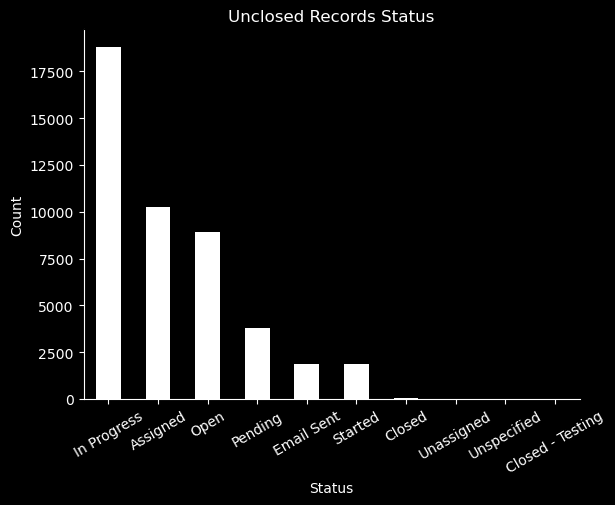

In [22]:
unclosed_status = df[(df['closed_date'].isnull())].groupby('status')['created_date'].count().sort_values(ascending=False)
ax = unclosed_status.plot.bar(title='Unclosed Records Status', ylabel='Count', xlabel='Status', color='w')#.to_clipboard()
ax.set_facecolor((0,0,0,0))
fig = ax.get_figure()
fig.set_facecolor('k')
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_color('white')

# Other customizations with white for inverted theme
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
ax.title.set_color('white')
ax.tick_params(axis='x', colors='white', rotation=30)
ax.tick_params(axis='y', colors='white')

In [23]:
df[(df['status']!='Closed')].groupby('agency')['closed_date'].count()
df[(df['borough']=='Unspecified') &  (df['latitude'].isnull()) & (df['incident_zip'].isnull())].count()
# unclosed = df[(df['status']!='Closed')|(df['closed_date'] == pd.NaT)]['agency'].value_counts()
# unclosed.plot.bar(title='Number of Unclosed Requests by Agency', xlabel='Agency', ylabel='Unclosed Request Count')
# unclosed = df[df['status']!='Closed']['agency'].value_counts()
# unclosed.plot.bar(title='Number of Unclosed Requests by Agency', xlabel='Agency', ylabel='Unclosed Request Count')

C:\Users\Morri\AppData\Local\Temp\ipykernel_8544\2750814593.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df[(df['status']!='Closed')].groupby('agency')['closed_date'].count()


created_date                      34205
closed_date                       30955
complaint_type                    34205
descriptor                        33991
status                            34205
resolution_description            34105
resolution_action_updated_date    18320
borough                           34205
incident_zip                          0
city                                  9
bbl                                   0
latitude                              0
longitude                             0
due_date                          19596
agency                            34205
dtype: int64

In [24]:
# remove null closed dates
df = df.loc[df['closed_date'].notnull()]

#### Feature Engineering

##### Add target feature

In [25]:
df['hours_to_complete'] =  pd.to_datetime(df['closed_date']) - pd.to_datetime(df['created_date'])
df['hours_to_complete'] = df.loc[:,'hours_to_complete'].astype('float64') / (3.6e12)

##### Add number of requests created by hour and grouped

##### Add number of requests open by hour grouped by features

In [28]:
# calculate number of open requests grouped by
# an element of the powerset of s
features= ['borough', 'agency','complaint_type']
add_powerset_created(df, features)

add_powerset_open(df, features)


general
0.116 seconds

borough
0.742 seconds

agency


C:\Users\Morri\AppData\Local\Temp\ipykernel_8544\3800869002.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  created_by_date = df.groupby(


0.587 seconds

complaint_type
0.802 seconds

borough agency


C:\Users\Morri\AppData\Local\Temp\ipykernel_8544\3800869002.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  created_by_date = df.groupby(


1.960 seconds

borough complaint_type
1.776 seconds

general
2.337 seconds

borough
3.169 seconds

agency


C:\Users\Morri\AppData\Local\Temp\ipykernel_8544\511794481.py:42: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  t_num_closed = df['closed_date'].groupby(level=list(range(df.index.nlevels))).count()
C:\Users\Morri\AppData\Local\Temp\ipykernel_8544\511794481.py:57: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  t_num_created = df['created_date'].groupby(level=list(range(df.index.nlevels))).count()


3.075 seconds

complaint_type
7.779 seconds

borough agency


C:\Users\Morri\AppData\Local\Temp\ipykernel_8544\511794481.py:42: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  t_num_closed = df['closed_date'].groupby(level=list(range(df.index.nlevels))).count()
C:\Users\Morri\AppData\Local\Temp\ipykernel_8544\511794481.py:57: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  t_num_created = df['created_date'].groupby(level=list(range(df.index.nlevels))).count()


9.076 seconds

borough complaint_type
90.959 seconds



In [30]:
df

general
3.686 seconds

borough
3.682 seconds

agency


C:\Users\Morri\AppData\Local\Temp\ipykernel_8544\511794481.py:42: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  t_num_closed = df['closed_date'].groupby(level=list(range(df.index.nlevels))).count()
C:\Users\Morri\AppData\Local\Temp\ipykernel_8544\511794481.py:57: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  t_num_created = df['created_date'].groupby(level=list(range(df.index.nlevels))).count()


3.825 seconds

complaint_type
9.247 seconds

borough agency


C:\Users\Morri\AppData\Local\Temp\ipykernel_8544\511794481.py:42: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  t_num_closed = df['closed_date'].groupby(level=list(range(df.index.nlevels))).count()
C:\Users\Morri\AppData\Local\Temp\ipykernel_8544\511794481.py:57: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  t_num_created = df['created_date'].groupby(level=list(range(df.index.nlevels))).count()


12.507 seconds

borough complaint_type
88.326 seconds



,borough,complaint_type,created_H,closed_H,agency,created_date,closed_date,descriptor,status,resolution_description,...,created_ag,created_co,created_bo_ag,created_bo_co,open,open_bo,open_ag,open_co,open_bo_ag,open_bo_co
0,QUEENS,Building/Use,2010-01-05 16:00:00,2018-06-29 00:00:00,DOB,2010-01-05 16:12:25,2018-06-29 00:00:00,Illegal Conversion Of Residential Building/Space,Closed,The Department of Buildings has investigated t...,...,1,1,1,1,<NA>,<NA>,<NA>,<NA>,<NA>,NaN
1,QUEENS,General Construction/Plumbing,2010-01-07 08:00:00,2018-09-18 00:00:00,DOB,2010-01-07 08:30:31,2018-09-18 00:00:00,Building Permit - None,Closed,The Department of Buildings investigated this ...,...,1,1,1,1,<NA>,<NA>,<NA>,<NA>,<NA>,NaN
2,MANHATTAN,General Construction/Plumbing,2010-01-11 11:00:00,2018-08-14 00:00:00,DOB,2010-01-11 11:54:41,2018-08-14 00:00:00,Egress - Doors Locked/Blocked/Improper/No Seco...,Closed,The Department of Buildings has investigated t...,...,1,1,1,1,<NA>,<NA>,<NA>,<NA>,<NA>,NaN
3,BROOKLYN,General Construction/Plumbing,2010-01-14 06:00:00,2018-11-01 00:00:00,DOB,2010-01-14 06:31:16,2018-11-01 00:00:00,Building Permit - None,Closed,The Department of Buildings investigated this ...,...,1,1,1,1,<NA>,<NA>,<NA>,<NA>,<NA>,NaN
4,QUEENS,Building/Use,2010-01-15 15:00:00,2018-08-01 00:00:00,DOB,2010-01-15 15:34:43,2018-08-01 00:00:00,Illegal Conversion Of Residential Building/Space,Closed,The Department of Buildings has investigated t...,...,1,1,1,1,<NA>,<NA>,<NA>,<NA>,<NA>,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2704382,STATEN ISLAND,Noise - Residential,2018-12-31 23:00:00,2018-12-31 23:00:00,NYPD,2018-12-31 23:08:31,2018-12-31 23:18:44,Loud Music/Party,Closed,The Police Department responded to the complai...,...,147,80,4,3,94966,5077,953,326,28,9
2704383,STATEN ISLAND,Noise - Residential,2018-12-31 23:00:00,2019-01-01 04:00:00,NYPD,2018-12-31 23:39:46,2019-01-01 04:09:14,Banging/Pounding,Closed,The Police Department responded to the complai...,...,147,80,4,3,94966,5077,953,326,28,9
2704384,STATEN ISLAND,Noise - Residential,2018-12-31 23:00:00,2019-01-01 07:00:00,NYPD,2018-12-31 23:14:00,2019-01-01 07:40:25,Loud Music/Party,Closed,The Police Department responded to the complai...,...,147,80,4,3,94966,5077,953,326,28,9
2704385,STATEN ISLAND,Sewer,2018-12-31 23:00:00,2019-01-02 09:00:00,DEP,2018-12-31 23:36:00,2019-01-02 09:30:00,Street Flooding (SJ),Closed,The Department of Environmental Protection ins...,...,13,8,1,1,94966,5077,4037,1661,185,63


In [33]:
df = df.convert_dtypes(dtype_backend="pyarrow")
df.dtypes

borough                                  string[pyarrow]
complaint_type                           string[pyarrow]
created_H                         timestamp[ns][pyarrow]
closed_H                          timestamp[ns][pyarrow]
agency                                          category
created_date                      timestamp[ns][pyarrow]
closed_date                       timestamp[ns][pyarrow]
descriptor                               string[pyarrow]
status                                   string[pyarrow]
resolution_description                   string[pyarrow]
resolution_action_updated_date    timestamp[ns][pyarrow]
incident_zip                             string[pyarrow]
city                                     string[pyarrow]
bbl                                      string[pyarrow]
latitude                                 double[pyarrow]
longitude                                double[pyarrow]
due_date                          timestamp[ns][pyarrow]
hours_to_complete              

##### Save new frame to a file

In [34]:
df.to_parquet(dir_2018/"processed", partition_cols=['agency'])